In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Y.Z.
"""
# import packages used in the project
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator #,LinearLocator, FormatStrFormatter
from sklearn import linear_model
from sklearn import metrics
# Personally built packages
# data_load_01 and data_load_01 are the two packages used to load the original data.
import data_load_01
import data_load_02
import warnings
warnings.filterwarnings('ignore')

In [2]:
# predefined functions
#---------------------------------------------------------------------------------------------------------#
# Function to calculate the cumulative distribution, which is used to \
# calculate the cdf of daily driving distances.
# The input is a series of driving distances.
# The output is a distribution (x, y), and the fitting function f.
#---------------------------------------------------------------------------------------------------------#
def cdf_se(se):
    se = se[se<=600]
    x = np.linspace(0,500,500) 
    length = len(se)
    y = [len(se[se<=x_values])/length for x_values in tqdm(x)]
    y_np = np.array(y)
    para = np.polyfit(x,y_np,deg = 10)
    f = np.poly1d(para)
    return x,y,f

#---------------------------------------------------------------------------------------------------------#
# Function to build a fast polynominal fitting function by using numpy.
# The input is two vectors x and y.
# The output includes the parameters and fitted function.
#---------------------------------------------------------------------------------------------------------#
def get_fit(x, y): # get para
    p = np.polyfit(x, y, deg=300)
    f = np.poly1d(p)
    return p, f

#---------------------------------------------------------------------------------------------------------#
# Function to reclassify fleet types
#---------------------------------------------------------------------------------------------------------#
def fleet_class(cell): # classify fleet type into pri/pub
    if cell == 'private':
        return 'pr'
    elif cell in ['taix', 'rental']:
        return 'pu'
    else: # official
        return cell

#---------------------------------------------------------------------------------------------------------#
# Function to make cdf dataframe.
# The input is the dataframe of daily distances by different regions and fleet types.
# The output is the dataframe of cdf function with categories.
#---------------------------------------------------------------------------------------------------------#
def cdf_df_make(daily_dist): # fleet types should include pr and pu
    cdf_list = []
    for reg in ['BJ', 'SH', 'GZ']:
        for ft in ['pr', 'pu']:
            # print('Start prossessing: %s, %s...'%(reg,ft))
            msk1 = daily_dist.region == reg
            msk2 = daily_dist.fleet_type2 == ft
            x,y,f = cdf_se(daily_dist.loc[(msk1 & msk2), 'dert_dist(km)'])
            cdf_list.append([reg, ft, x, y, f])
    cols = ['region', 'fleet_type', 'x_arr', 'y_arr', 'func']
    cdf_df = pd.DataFrame(cdf_list, columns=cols)
    return cdf_df

#---------------------------------------------------------------------------------------------------------#
# Function to get the function of probability -> daily driving distance.
# The input is cdf dataframe, (x is distances and y is probability).
# The output is the reverse between x and y.
#---------------------------------------------------------------------------------------------------------#
def get_reverse_func(cdf_df): 
    cdfr_list = []
    for reg in ['BJ', 'SH', 'GZ']:
        for ft in ['pr', 'pu']:
            # print('Start prossessing: %s, %s...'%(reg,ft))
            msk1 = cdf_df.region == reg
            msk2 = cdf_df.fleet_type == ft
            cdf_tmp = cdf_df.loc[msk1 & msk2, :]
            x = cdf_tmp.loc[:,'x_arr'].iloc[0]
            y = cdf_tmp.loc[:,'y_arr'].iloc[0]
            para, func = get_fit(y, x)
            cdfr_list.append([reg, ft, para, func])
    cols = ['region', 'fleet_type', 'p', 'f']
    cdfr_df = pd.DataFrame(cdfr_list, columns=cols)
    return cdfr_df

#---------------------------------------------------------------------------------------------------------#
# Class to build the fast polynominal fitting model by using numpy.
# When training, the input is vector x, vector y, and the degree of the polynominal model, \
# and the output includes the parameters and the fitted model.
# When testing, the input is the vector x to be predicted, and the output is predicted vector y.
#---------------------------------------------------------------------------------------------------------#
class model_fit_poly_1d(object):
    def __init__(self,deg):
        self.f_ = None
        self.p_ = None
        self.deg = deg
    def fit(self,x,y):
        self.f_ = np.polyfit(x,y,self.deg)
        self.p_ = np.poly1d(self.f_)
    def predict(self,x_pre):
        poly_fit = self.p_(x_pre)
        return poly_fit
    def para(self):
        return self.f_

#---------------------------------------------------------------------------------------------------------#
# Function to calculate unavailable battery energy.
# The input includes battery energy and max wasted proportion induced by different variables.
# The output is total waste energy.
#---------------------------------------------------------------------------------------------------------#
def waste_energy(e, max_temp_waste, max_age_waste, x1, x2):
    y1 = e * (1 - (1 - max_temp_waste*(1-x1)) * (1 - max_age_waste*(1-x2)))
    return y1

#---------------------------------------------------------------------------------------------------------#
# Function to get a color palette.
#---------------------------------------------------------------------------------------------------------#
def get_ggplot_palette():
    plt.style.use('ggplot')
    color_palette_ggplot = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # sns.palplot(color_palette_ggplot)
    plt.style.use('default')
    return color_palette_ggplot

#---------------------------------------------------------------------------------------------------------#
# Function to calculate the SOC distribution when vehicle is in driving states.
# The input consists of the vector of starting SOCs, the vector of ending SOCs, and a designated column number.
# The output is a matrix to record SOC intervals.
#---------------------------------------------------------------------------------------------------------#
def drv_matrix(start_soc_arr, end_soc_arr, num):
    start_soc_arr = start_soc_arr.astype(int)
    end_soc_arr = end_soc_arr.astype(int)
    l = len(start_soc_arr)
    record_mat = np.zeros((l, num))
    for i in range(l):
        if start_soc_arr[i] >= end_soc_arr[i]:
            record_mat[i, end_soc_arr[i]:start_soc_arr[i]] = 1
    return record_mat

#---------------------------------------------------------------------------------------------------------#
# Function to calculate the SOC distribution when vehicle is in charging states.
# The input consists of the vector of starting SOCs, the vector of ending SOCs, and a designated column number.
# The output is a matrix to record SOC intervals.
#---------------------------------------------------------------------------------------------------------#
def chg_matrix(start_soc_arr, end_soc_arr, num):
    start_soc_arr = start_soc_arr.astype(int)
    end_soc_arr = end_soc_arr.astype(int)
    l = len(start_soc_arr)
    record_mat = np.zeros((l, num))
    for i in range(l):
        if start_soc_arr[i] <= end_soc_arr[i]:
            record_mat[i, start_soc_arr[i]:end_soc_arr[i]] = 1
    return record_mat

#---------------------------------------------------------------------------------------------------------#
# Function to classify LDEVs.
#---------------------------------------------------------------------------------------------------------#
def vehicle_cls3(cell):
    if cell in ['私人乘用车', '公务乘用车', '租赁乘用车', '出租乘用车']:
        return 'LDEV'

#---------------------------------------------------------------------------------------------------------#
# Set up month lists.
#---------------------------------------------------------------------------------------------------------#
Month = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'Jun.',
         'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.','Dec.']
Month = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11','12']
Month2 = ['', 'Feb.', '', 'Apr.', '', 'Jun.', 
          '', 'Aug.', '', 'Oct.', '','Dec.']

In [3]:
    #---------------------------------------------------------------------------------------------------------#   
    # Load dynamic EV operating data and vehicle specification data.
    # Connect the information from two data sources.
    # Create a new dataframe object.
    #---------------------------------------------------------------------------------------------------------#
    data_op = data_load_01.get_operating_data_auto()
    data_info = data_load_02.get_veh_info() # data specification data
    data_op_p1 = pd.merge(data_op, data_info, 
                          left_on='b.vin', right_on='vin') # merge dynamic and static data
    data_op_p2 = data_op_p1.copy() #copy

In [4]:
    #---------------------------------------------------------------------------------------------------------#
    # Data preprocessing.
    # Create some new features, including delta distanc, delta SOC, etc.
    # Filter vehicle states, data faults, designated SOC intervals, etc.
    #---------------------------------------------------------------------------------------------------------#
    msk1 = data_op_p2.city == '北京市'#'北京' Beijing, '广州市' Guangzhou，‘上海市’ Shanghai
    # vehicle model can be selected as specific requirements.
    msk2 = data_op_p2.veh_model == '1a5afe0eb2520bdfa00134b987268a8b' #choose vehicle model
    msk3 = data_op_p2['b.category'] == 10 # 10 and 30 for driving and charging sessions.
    msk =  msk2 & msk3 & msk1
    data_op_p3 = data_op_p2.loc[msk, :] 
    data_op_p4 = data_op_p3.copy() #copy
    # To obtain the driving distances of individual sesssions.
    data_op_p4['dert_dist'] = (data_op_p4['b.stop_mileage'] - data_op_p4['b.start_mileage'])
    data_op_p4['dert_soc'] = data_op_p4['b.start_soc'] - data_op_p4['b.end_soc']
    data_op_p4['normalized_range'] = 100 * data_op_p4['dert_dist']/data_op_p4['dert_soc']   
    msk1 = data_op_p4['b.start_temp'] > -20
    msk2 = data_op_p4['dert_soc'] > 5
    msk3 = data_op_p4['normalized_range'] > 40
    msk4 = (data_op_p4['b.start_soc'] <= 95) & (data_op_p4['b.start_soc'] >= 35)
    msk5 = (data_op_p4['b.end_soc'] <= 95) & (data_op_p4['b.end_soc'] >= 35)
    msk =  msk1 & msk2 & msk3 & msk4 & msk5 
    data_op_p4 = data_op_p4.loc[msk, :]
    del msk1, msk2, msk3, msk

Text(0, 0.5, 'Range decline ratio (%)')

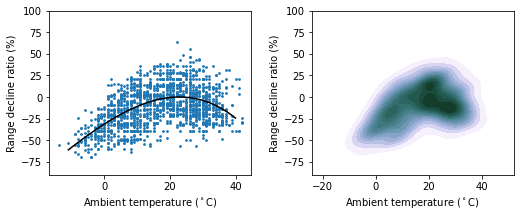

In [5]:
    #---------------------------------------------------------------------------------------------------------#
    # Select data from the dataframe of real-world EV operating data.
    # Calculate the rate of range declines.
    # Train a model to obtain the relationship between the ambient temperature and range decline ratio.
    # Plot the curves between varibales and decline ratios.
    #---------------------------------------------------------------------------------------------------------#
    # Get x and y.
    x = data_op_p4['b.start_temp']
    x_np = np.linspace(-11, 40, 100)
    y1 = data_op_p4['normalized_range']
    # Initiate models with different parameters.
    model_fit1 = model_fit_poly_1d(1)
    model_fit1.fit(x, y1)
    model_fit3 = model_fit_poly_1d(3)
    model_fit3.fit(x, y1)
    model_fit5 = model_fit_poly_1d(5)
    model_fit5.fit(x, y1)
    model_fitx = model_fit_poly_1d(10)
    model_fitx.fit(x, y1)
    optimal_avg_range = model_fit3.predict(22)
    y = 100 * (data_op_p4['normalized_range'] - optimal_avg_range)/optimal_avg_range
    # Polynomial fitting model construction
    model_fit = model_fit_poly_1d(3)
    # Line fitting
    model_fit.fit(x, y)
    # Get parameters for the fitted line
    para = model_fit.para()
    optimal_avg_range = model_fit.predict(22)
    # Construct a figure.
    fig = plt.figure(figsize=((7.5, 3))) # plot
    plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, 
                        top=0.96, wspace=0.3, hspace=0.30)
    ax1 = fig.add_subplot(121)
    ax1.scatter(x, y, s=3)
    ax1.plot(x_np, model_fit.predict(x_np), c='k')
    ax1.set_ybound(-90, 100)
    ax1.set_xlabel('Ambient temperature ($^\circ$C)')
    ax1.set_ylabel('Range decline ratio (%)')
    ax2 = fig.add_subplot(122)
    cmap = sns.cubehelix_palette(start=2, light=1, as_cmap=True)
    sns.kdeplot(x=x, y=y,cmap=cmap, fill=True,levels=15,ax=ax2,)
    ax2.set_ybound(-90, 100)
    ax2.set_xlabel('Ambient temperature ($^\circ$C)')
    ax2.set_ylabel('Range decline ratio (%)')

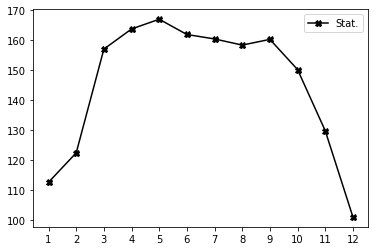

In [6]:
    #---------------------------------------------------------------------------------------------------------#    
    # Statistical changes of ranges across varied regions and during twelve months.
    # Basic precedures are in four steps:
    # Select data from the dataframe of real-world EV operating data.
    # Calculate statistical averages of driving ranges.
    # Aggregate the results by different varibles (regions and months).
    # Plot the statistical results on the horizon of twelve Months.
    #---------------------------------------------------------------------------------------------------------#
    Month = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11','12']
    data_op_p4['start_time'] = pd.to_datetime(data_op_p4['b.st_time_e'],unit='ms') + pd.DateOffset(hours=8)#unix time
    data_op_p4['end_time'] = pd.to_datetime(data_op_p4['b.et_time_e'],unit='ms')+ pd.DateOffset(hours=8)
    norm_rg_lst = []
    for i in range(1, 13, 1):
        msk1 = data_op_p4['start_time'].dt.year == 2019
        msk2 = data_op_p4['start_time'].dt.month == i
        block_tmp = data_op_p4.loc[msk1 & msk2, 'normalized_range'].copy()
        norm_rg_lst.append(block_tmp.mean())
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(Month, norm_rg_lst, '-X', color='k', label='Stat.')
    ax.legend(loc='upper right')

In [7]:
    #---------------------------------------------------------------------------------------------------------#
    # Create matrices of cumulative distribution functions (cdf).
    # The input is original EV data.
    # The output is a cdf function.
    #---------------------------------------------------------------------------------------------------------#
    # Loading daily driving datasets
    daily_dist = data_load_02.get_daily_dist() # load data
    # fleet type reclassifications
    daily_dist['fleet_type2'] = daily_dist['fleet_type'].apply(fleet_class) 
    # make cdf
    cdf_df = cdf_df_make(daily_dist) 
    cdfr_df = get_reverse_func(cdf_df)
    color_palette_ggplot = get_ggplot_palette()

100%|██████████| 500/500 [00:01<00:00, 256.18it/s]


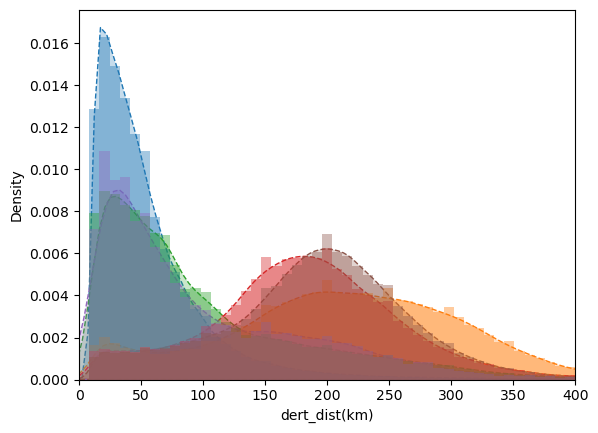

In [8]:
    #---------------------------------------------------------------------------------------------------------#
    # Plot the distributions of daily driving distances.
    # In this cell, the distributions are displayed by different regions and fleet types.
    # Three regions, Beijing, Shanghai, and Guangzhou, are focused.
    # Two fleet types, private and public vehicles are targetted.
    #---------------------------------------------------------------------------------------------------------#
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    bins = np.linspace(0,400, 50)
    for reg in ['BJ', 'SH', 'GZ']:
        for ft in ['pr', 'pu']:
            # Distinguish regions and fleet types.
            # Build masks for dataframe.
            msk1 = daily_dist.region == reg
            msk2 = daily_dist.fleet_type2 == ft
            # Filter data by masks.
            data_tmp = daily_dist.loc[msk1 * msk2, 'dert_dist(km)']
            sns.distplot(data_tmp, hist=True, #color='b',
                          kde_kws={"shade": True,'linewidth':1,'linestyle':'--'},
                          bins=bins, 
                          ax=ax1, label='%s, %s'%(reg, ft))#, color="#3C5488FF", color="g"
    ax1.set_xbound(0, 400)
    plt.show()
    del bins

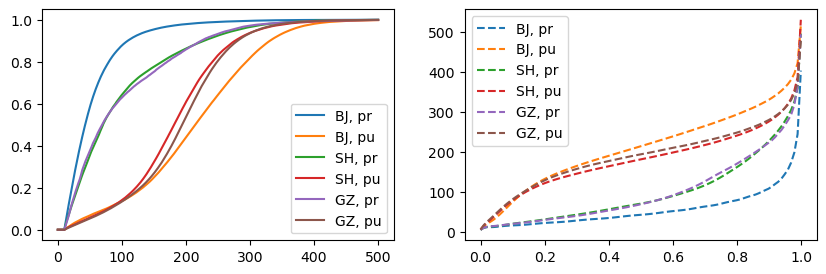

In [9]:
    #---------------------------------------------------------------------------------------------------------#
    # cdf curves of varied regions and fleet types.
    # Also plot the reverse function.
    # Three regions, Beijing, Shanghai, and Guangzhou, are focused.
    # Two fleet types, private and public vehicles are targetted.
    #---------------------------------------------------------------------------------------------------------#
    fig = plt.figure(figsize=(10, 3))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    for reg in ['BJ', 'SH', 'GZ']:
        for ft in ['pr', 'pu']:
            # Varied regions and fleet types.
            msk1 = cdf_df.region == reg
            msk2 = cdf_df.fleet_type == ft
            se = cdf_df.loc[msk1 & msk2, :]
            ax1.plot(se['x_arr'].iloc[0], se['y_arr'].iloc[0], label='%s, %s'%(reg, ft))
            se_r = cdfr_df.loc[msk1 & msk2, :]
            # Get x and f
            x = np.linspace(0, 0.999, 100)
            f = se_r['f'].iloc[0]
            ax2.plot(x, f(x), '--', label='%s, %s'%(reg, ft))
    ax1.legend(loc='lower right')
    ax2.legend(loc='upper left')
    plt.show()

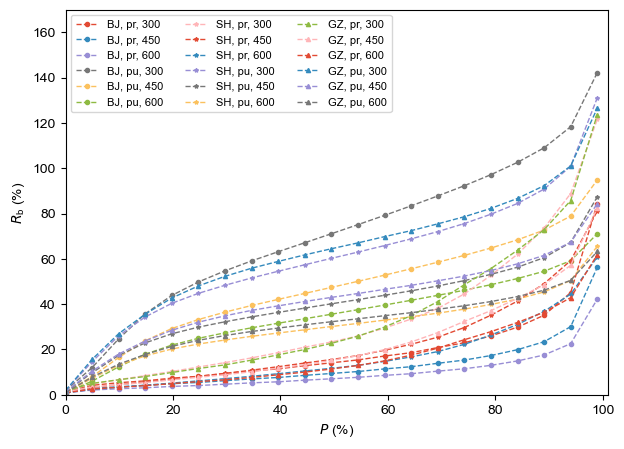

In [10]:
    #---------------------------------------------------------------------------------------------------------#
    # Calculate battery utilization rates for different regions and fleet types.
    #---------------------------------------------------------------------------------------------------------#
    f_size = 10
    font = {'size': f_size} 
    plt.rcParams['font.family'] = 'Arial'
    fig = plt.figure(figsize=(7,5))
    ax_sup1 = fig.add_subplot(111)
    ax_sup1.set_prop_cycle(color=color_palette_ggplot)
    xp = np.linspace(0, 0.99, 21)
    # Set up line style.
    lw_line = 1
    ms = 3
    # Varied regions and fleet types.
    for reg, marker_style in zip(['BJ', 'SH', 'GZ'], ['o', '*', '^']):
        for ft in ['pr', 'pu']:
            for dist in [300, 450, 600]:
                # Build masks.
                msk1 = cdfr_df.region == reg
                msk2 = cdfr_df.fleet_type == ft
                f = cdfr_df.loc[msk1 & msk2, 'f'].iloc[0]
                # Plot the BUR with probability.
                ax_sup1.plot(xp,f(xp)/dist,'--o',c=None,linewidth=lw_line, 
                             markersize=ms,marker=marker_style, 
                             label='%s, %s, %s'%(reg, ft, dist))#, '-',c='tomato'
    # Set up the property of the axis.
    ax_sup1.legend(loc='upper left', fontsize=8, ncol=3)
    ax_sup1.set_ybound(0,1.7)
    ax_sup1.set_xbound(0,1.01)
    ax_sup1.tick_params(labelsize=f_size)
    xmajorLocator = MultipleLocator(0.2)
    ax_sup1.xaxis.set_major_locator(xmajorLocator)
    vals = ax_sup1.get_xticks()
    # ax_sup1.set_xticks(ax_sup1.get_xticks().tolist())
    ax_sup1.set_xticklabels(['{:,.0f}'.format(x*100) for x in vals])
    vals = ax_sup1.get_yticks()
    ax_sup1.set_yticklabels(['{:,.0f}'.format(x*100) for x in vals])
    ax_sup1.set_xlabel('$P$ (%)',font)
    ax_sup1.set_ylabel('$R_\mathregular{b}$ (%)',font)
    del reg, ft, dist

In [11]:
    #---------------------------------------------------------------------------------------------------------#
    # Extract the relationship between ambient temperatures and n-ranges. 
    # The input data is processed vehicular operating data.
    # Train a regression model to record the changes of EV range changes.
    # The output is trained models and relevant parameters.
    #---------------------------------------------------------------------------------------------------------#
    # Data screening
    msk1 = data_op_p2.city == '北京市'#filter for '北京' Beijing, '广州市' Guangzhou，‘上海市’ Shanghai
    # vehicle model can be selected as specific requirements.
    msk2 = data_op_p2.veh_model == '1a5afe0eb2520bdfa00134b987268a8b' #choose model
    msk3 = data_op_p2['b.category'] == 10 # 10 and 30 for driving and charging sessions.
    msk = msk1 & msk2 & msk3
    data_op_p3 = data_op_p2.loc[msk, :]
    data_op_p4 = data_op_p3.copy() #copy
    # To obtain the driving distances of individual sesssions.
    data_op_p4['dert_dist'] = (data_op_p4['b.stop_mileage'] - data_op_p4['b.start_mileage'])
    data_op_p4['dert_soc'] = data_op_p4['b.start_soc'] - data_op_p4['b.end_soc']
    data_op_p4['normalized_range'] = 100 * data_op_p4['dert_dist']/data_op_p4['dert_soc']
    # Build masks for data selection.
    msk1 = data_op_p4['b.start_temp'] > -20
    msk2 = data_op_p4['dert_soc'] > 5
    msk3 = data_op_p4['normalized_range'] > 40
    msk4 = (data_op_p4['b.start_soc'] <= 95) & (data_op_p4['b.start_soc'] >= 35)
    msk5 = (data_op_p4['b.end_soc'] <= 95) & (data_op_p4['b.end_soc'] >= 35)
    msk =  msk1 & msk2 & msk3 & msk4 & msk5
    data_op_p4 = data_op_p4.loc[msk, :]
    del msk1, msk2, msk3, msk
    # Rates of range declines
    x = data_op_p4['b.start_temp']
    x_np = np.linspace(-11, 40, 100)
    y1 = data_op_p4['normalized_range']
    model_fit1 = model_fit_poly_1d(1)
    model_fit1.fit(x, y1)
    model_fit3 = model_fit_poly_1d(3)
    model_fit3.fit(x, y1)
    model_fit5 = model_fit_poly_1d(5)
    model_fit5.fit(x, y1)
    model_fitx = model_fit_poly_1d(10)
    model_fitx.fit(x, y1)
    optimal_avg_range = model_fit3.predict(22)
    y = 100 * (data_op_p4['normalized_range'] - optimal_avg_range)/optimal_avg_range
    model_fit = model_fit_poly_1d(3) # polynomial fitting model construction
    model_fit.fit(x, y) # line fitting
    para = model_fit.para() # parameters for the fitted line
    # optimal_avg_range = model_fit.predict(22)

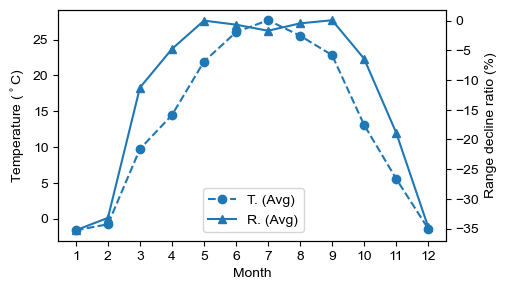

In [12]:
    #---------------------------------------------------------------------------------------------------------#
    # Compute the range changes in different spatiotemporal conditions.
    # Process the regional temperture data and apply the range change model to them.
    #---------------------------------------------------------------------------------------------------------#
    # Loading regional temperature data.
    data_city_temp = data_load_02.get_ambient_temp()
    # Build masks.
    msk1 = data_city_temp.Region == 'Beijing'
    msk2 = data_city_temp.Item == 'Avg'
    # Conduct the selection.
    data_city_temp_p1 = data_city_temp.loc[msk1 & msk2, 'January':'December']
    months = data_city_temp_p1.columns
    # Deal with temperature data.
    months = [str(int(s)) for s in range(1, 13, 1)]
    temps_avg = data_city_temp_p1.values.reshape(-1)
    del msk1, msk2
    # Declines in regions and during months generated by a general model.
    fig = plt.figure(figsize=((5, 3))) # plot
    # Plot the curves.
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    ax1.plot(months, temps_avg, '--o', label='T. (Avg)')
    ax2.plot(months, model_fit.predict(temps_avg), '-^', label='R. (Avg)')
    ax1.set_xlabel('Month') 
    ax1.set_ylabel('Temperature ($^\circ$C)')
    ax2.set_ylabel('Range decline ratio (%)')
    fig.legend(loc=(0.4, 0.2))

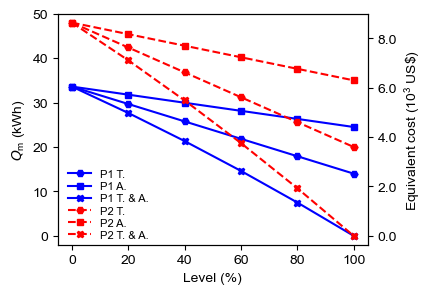

In [13]:
    #---------------------------------------------------------------------------------------------------------#
    # Averge and worst case calculations
    # Caculate waste parts induced by varied reasons.
    # Compute the development levels of batteries through reducing the negtive impact.
    # Obtain the joint-relationships between unavailable parts, initial energy, and development level.
    #---------------------------------------------------------------------------------------------------------#
    # Process the regional temperature dataframe.
    region_temp2 = data_city_temp.T
    region_bu = region_temp2.loc['January':, :].applymap(model_fit.predict) # model_fit.predic can be any model refecting performance changes
    region_bu = pd.concat([region_temp2.loc[['Region','Item'],:], region_bu])
    region_plot = pd.DataFrame()
    regions = data_city_temp.Region.unique()
    for region in regions:
        maskcol1 = (region_bu.loc['Region', :]==region)
        maskcol2 = (region_bu.loc['Item', :]=='Avg')
        temp = region_bu.loc[:, maskcol1]
        #min df in the three cols，use idmin to get the col of mins
        min_col = temp.loc['January':'December', :].astype(float).min().idxmin() 
        min_month = temp.loc['January':'December', min_col].astype(float).idxmin()
        min_value = temp.loc[min_month, min_col]
        avg_value = temp.loc['January':'December', temp.loc['Item',:]=='Avg'].mean()
        dftemp = pd.DataFrame({'Region':region, 'Avg': avg_value, 
                               'min':min_value, 'min month': min_month})
        region_plot = pd.concat([region_plot, dftemp])
    # Changes of unavailable battery energy with improvements of battery technology.
    x = np.linspace(0, 1, 6)
    region_bu2 = region_bu.T.set_index(['Region', 'Item'])
    _block = region_bu.loc['January':'December',0:2]
    # max_temp_waste = 1 - _block.min().min()
    max_temp_waste=0.35 # derive from max range declines in varied regions.
    max_age_waste=0.2
    # Initiate battery energy for the first category.
    e = 70 #'70 kWh'
    x1, x2 = x, 0
    y1 = waste_energy(e, max_temp_waste, max_age_waste, x1, x2)
    x1, x2 = 0, x
    y2 = waste_energy(e, max_temp_waste, max_age_waste, x1, x2)
    x1, x2 = x, x
    y3 = waste_energy(e, max_temp_waste, max_age_waste, x1, x2)
    x1, x2 = x*0.5, x
    y4 = waste_energy(e, max_temp_waste, max_age_waste, x1, x2)
    x1, x2 = x, x*0.5
    y5 = waste_energy(e, max_temp_waste, max_age_waste, x1, x2)
    #'unavailable energy'
    x1, x2 = 0, 0
    output0 = waste_energy(e, max_temp_waste, max_age_waste, x1, x2)
    x1, x2 = 0.8, 0 #temperature 80%
    output1 = waste_energy(e, max_temp_waste, max_age_waste, x1, x2)
    x1, x2 = 0, 0.8 #aging 80%
    output2 = waste_energy(e, max_temp_waste, max_age_waste, x1, x2)
    # print(output0, output1, output2)
    # Plot the figure.
    fig = plt.figure(figsize=(4, 3)) # plot
    _ax1 = fig.add_subplot(111)
    _ax1.plot(x, y1,'-H', c = 'b', label='P1 T.', linewidth=1.5, markersize=5)
    _ax1.plot(x, y2,'-s', c = 'b', label='P1 A.', linewidth=1.5, markersize=5)
    _ax1.plot(x, y3,'-X', c = 'b', label='P1 T. & A.', linewidth=1.5, markersize=5)
    # Initiate battery energy for the first category.
    e3=100 #'100 kWh'
    e, x1, x2 = e3, x, 0
    y1 = waste_energy(e, max_temp_waste, max_age_waste, x1, x2)
    e, x1, x2 = e3, 0, x
    y2 = waste_energy(e, max_temp_waste, max_age_waste, x1, x2)
    e, x1, x2 = e3, x, x
    y3 = waste_energy(e, max_temp_waste, max_age_waste, x1, x2)
    e, x1, x2 = e3, x*0.5, x
    y4 = waste_energy(e, max_temp_waste, max_age_waste, x1, x2)
    e, x1, x2 = e3, x, x*0.5
    y5 = waste_energy(e, max_temp_waste, max_age_waste, x1, x2)
    _ax1.plot(x, y1,'--H', c = 'r', label='P2 T.', linewidth=1.5, markersize=5)
    _ax1.plot(x, y2,'--s', c = 'r', label='P2 A.', linewidth=1.5, markersize=5)
    _ax1.plot(x, y3,'--X', c = 'r', label='P2 T. & A.', linewidth=1.5, markersize=5)
    _ax1.legend(fontsize=8,loc=(0.02,0),ncol=1,frameon =False,
                columnspacing=0.9, labelspacing=0.2)
    _ax1.set_ybound(-2,50)
    _ax1.set_xlabel('Level (%)')
    _ax1.set_ylabel('$Q_\mathregular{m}$ (kWh)')
    vals = _ax1.get_xticks()
    _ax1.set_xticklabels(['{:,.0f}'.format(x*100) for x in vals])
    _ax2 = _ax1.twinx() #'100 kWh'
    unit_cost = 180
    _ax2.set_ybound(np.array(_ax1.get_ybound())*unit_cost)
    _ax2.set_ylabel('Equivalent cost (10$^\mathregular{3}$ US\$)')
    _ax2.set_ybound(np.array(_ax1.get_ybound())*unit_cost/1000)
    _ax2.set_yticklabels(['{:.1f}'.format(val) for val in _ax2.get_yticks()])
    
    del x, x1, x2, e, e3, y1, y2, y3, y4, y5, \
    max_temp_waste, max_age_waste, _block, vals

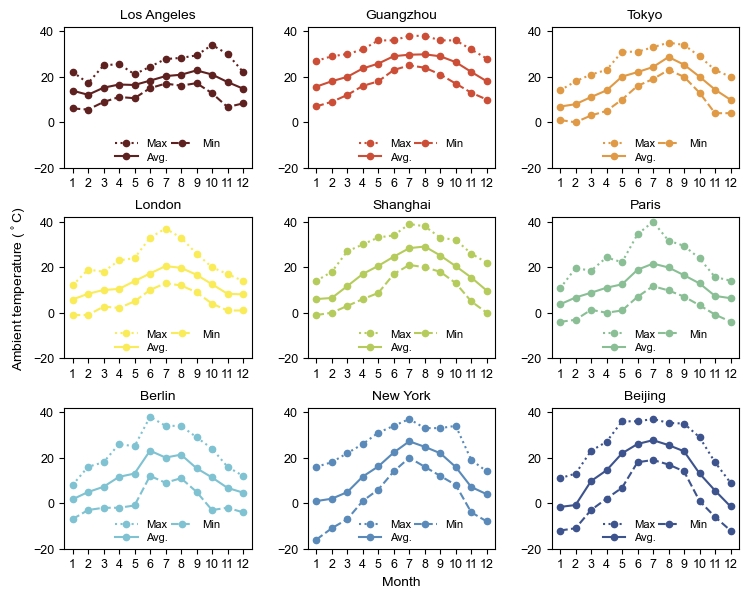

In [14]:
    #---------------------------------------------------------------------------------------------------------#
    # Display temperatures during 12 months and across 9 regions.
    #---------------------------------------------------------------------------------------------------------#
    # Figure setup.
    plt.style.use('default')
    plt.rcParams['font.family'] = 'Arial'
    f_size = 10
    font = {'size': f_size}
    font2 = {'size': f_size-2} 
    ms=4.5
    color_c = ['#292D64','#334382','#3D538D', '#598AB9','#7FC2D2','#8ABF95',
               '#B5CC5C','#F9EC58','#E09A46', '#CD4E36','#BB3633','#5F2120']
    color_c.reverse()
    color_ = [color_c[0]] + color_c[2:-2]
    order_list = [4, 2, 8, 5, 1, 6, 7, 3, 0]
    ii=0
    fig = plt.figure(figsize=(7.5,6))
    plt.subplots_adjust(left=0.08, bottom=0.08, right=0.98, 
                        top=0.95, wspace=0.3, hspace=0.350)
    region_temp = data_city_temp.copy()
    regions = data_city_temp.Region.unique()
    for i in order_list:
        ax = fig.add_subplot(3, 3, ii + 1)
        'Draw lines in 3 categories'
        mask1 = region_temp.Item=='Max'
        mask2 = region_temp.Item=='Avg'
        mask3 = region_temp.Item=='Min'
        msk = region_temp.Region==regions[i]
        temp1 = region_temp.loc[mask1 & msk, 'January':'December'].values.ravel()
        temp2 = region_temp.loc[mask2 & msk, 'January':'December'].values.ravel()
        temp3 = region_temp.loc[mask3 & msk, 'January':'December'].values.ravel()
        ax.plot(Month, temp1,':o', label = 'Max', markersize=ms,
                  linewidth=1.5, c=color_[ii],)
        ax.plot(Month, temp2,'-o', label = 'Avg.', markersize=ms,
                  linewidth=1.5, c=color_[ii],)
        ax.plot(Month, temp3,'--o', label = 'Min', markersize=ms,
                  linewidth=1.5, c=color_[ii],)
        ax.set_ybound(-20, 42)
        ax.tick_params(labelsize=f_size-1)
        # ax.set_xticklabels(Month2)
        ax.set_title(regions[i], font)
        if ii == 7:
            ax.set_xlabel('Month',font)
        if ii == 3:
            ax.set_ylabel('Ambient temperature ($^\circ$C)',font)
        # ax1_.set_yticklabels([ '{:,.0f}'.format(x*100) for x in ax1_.get_yticks()])
        ax.legend(fontsize=f_size-2,loc=(0.25, 0.01),ncol=2,frameon =False,
                  columnspacing=0.2, labelspacing=0.3)
        ii = ii + 1
        del temp1, temp2, temp3, mask1, mask2, mask3, msk

Text(0.37, 0.88, 'Interval [35, 95] accounts for 86–87%\nof total SOC usage')

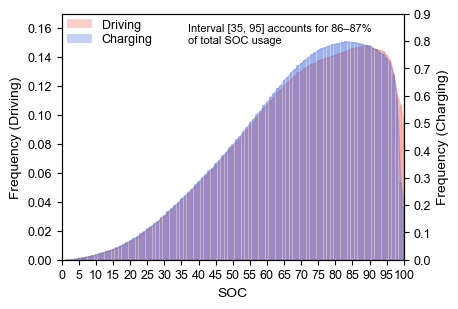

In [15]:
    #---------------------------------------------------------------------------------------------------------#
    # SOC interval coverage.
    # Calculate the distributions of SOC usage for varied vehicle modes and in different regions.
    # Get the coverage of different SOC intervals.
    #---------------------------------------------------------------------------------------------------------#
    # Build masks for selection demand.
    msk1 = data_op_p1.city == '北京市' # 上海，广州
    msk2 = data_op_p1.fuel_type == '纯电动'
    msk3 = data_op_p1['b.category'] == 10
    msk4 = data_op_p1['b.category'] == 30
    d1 = data_op_p1.loc[msk1 & msk2 & msk3, :]
    f1 = len(d1)
    drv_start_soc_arr = d1['b.start_soc'].values
    drv_end_soc_arr = d1['b.end_soc'].values
    d2 = data_op_p1.loc[msk1 & msk2 & msk4, :]
    f2 = len(d2)
    chg_start_soc_arr = d2['b.start_soc'].values
    chg_end_soc_arr = d2['b.end_soc'].values
    # Calculate the value of small bins.
    drv_record_mat = drv_matrix(drv_start_soc_arr, drv_end_soc_arr, 100)
    chg_record_mat = chg_matrix(chg_start_soc_arr, chg_end_soc_arr, 100)
    drv_rec = drv_record_mat.sum(axis=0)
    chg_rec = chg_record_mat.sum(axis=0)
    # print(drv_rec[35:95].sum()/drv_rec.sum(), chg_rec[35:95].sum()/chg_rec.sum())
    from matplotlib.ticker import MultipleLocator
    # 'soc interval'
    # Set up figure.
    plt.style.use('default')
    plt.rcParams['font.family'] = 'Arial'
    f_size = 10
    font = {'size': f_size}
    font2 = {'size': f_size-2} 
    fig = plt.figure(figsize=(4.5, 3))
    plt.subplots_adjust(left=0.12, bottom=0.15, right=0.88, 
                        top=0.97, wspace=0.17, hspace=0.30)
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    # Plot the distributions.
    ax.fill_between(np.arange(1, 101, 1), drv_rec/f1, alpha=0.3, color='tomato')
    ax2.fill_between(np.arange(1, 101, 1), chg_rec/f2, alpha=0.3, color='royalblue')
    ax.bar(np.arange(1, 101, 1), drv_rec/f1, alpha=0.3, color='tomato', label='Driving')
    ax2.bar(np.arange(1, 101, 1), chg_rec/f2, alpha=0.3, color='royalblue', label='Charging')
    # Chart configuration.
    xmajorLocator = MultipleLocator(5)
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.set_xlabel('SOC', font)
    ax.set_ylabel('Frequency (Driving)', font)
    ax2.set_ylabel('Frequency (Charging)', font)
    ax.set_xbound(0, 100)
    ax2.set_xbound(0, 100)
    ax.set_ybound(0, 0.17)
    ax2.set_ybound(0, 0.9)
    ax.tick_params(labelsize=f_size-1)
    ax2.tick_params(labelsize=f_size-1)
    ax.legend(fontsize=f_size-1,ncol=1,loc=(0,0.91) , frameon=False,
              columnspacing=1,labelspacing=0.3,borderaxespad=0.1)
    ax2.legend(fontsize=f_size-1,ncol=1,loc=(0,0.85) , frameon=False,
              columnspacing=1,labelspacing=0.3,borderaxespad=0.1)
    ax.text(0.37, 0.88, 'Interval [35, 95] accounts for 86–87%\nof total SOC usage' , fontsize=8, transform=ax.transAxes)

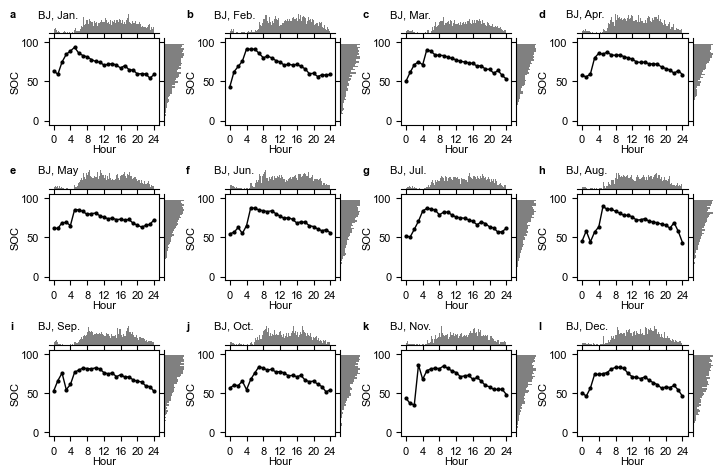

In [16]:
    #---------------------------------------------------------------------------------------------------------#
    # 2-dimensional/joint distributions of vehicle SOC utilization states and experienced times.
    # Process the data of variable SOC and operating times.
    # Calculate the average of the SOC of EVs at different hours.
    # The input is original operating data
    # The output is a 2d histgram of SOCs and operating times.
    #---------------------------------------------------------------------------------------------------------#
    # SOC distributions
    # Convert temporal data into a datetime format.
    data_op_p1['start_time_dt'] = pd.to_datetime(data_op_p1['b.st_time_e'], unit='ms') + pd.DateOffset(hours=8)
    data_op_p1['end_time_dt'] = pd.to_datetime(data_op_p1['b.et_time_e'], unit='ms') + pd.DateOffset(hours=8)
    msk11 = data_op_p1.city == '北京市' #BJ
    # msk12 = data_op_p1.city == '广州市'  #GZ
    msk2 = data_op_p1.fuel_type == '纯电动'
    msk3 = data_op_p1['b.category'] == 10
    msk4 = data_op_p1['b.category'] == 30
    msk5 = data_op_p1['fleet_type'].apply(vehicle_cls3) == 'LDEV'
    d01 = data_op_p1.loc[msk11 & msk2 & msk5, :]
    # d02 = data_op_p1.loc[msk12 & msk2 & msk5, :]
    Month = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'Jun.',
             'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.','Dec.']
    # Configure the chart.
    plt.style.use('default')
    plt.rcParams['font.family'] = 'Arial'
    fig = plt.figure(figsize=(7.2, 4.5))
    plt.subplots_adjust(left=0.068, bottom=0.05, right=0.99, top=0.99, wspace=0.3, hspace=0.4)
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from matplotlib.ticker import MultipleLocator
    bj_list = []
    text_x, text_y = -0.1, 0.8
    ii = 0
    for i in np.arange(1, 13, 1):
        ii = ii + 1
        ax = fig.add_subplot(3, 4, ii)
        # Make a selection.
        d0_p = d01.loc[d01.start_time_dt.dt.month==i]
        x = d0_p['start_time_dt'].dt.hour * 60 + d0_p['end_time_dt'].dt.minute
        y = d0_p['b.start_soc']
        # x and y are one-to-one match
        bin_1 = pd.cut(x, bins=np.arange(-30, 1440+60, 60), labels=False)
        bin_2 = pd.concat([x, y, bin_1], axis=1)
        bin_2.columns = ['minute', 'soc', 'label']
        bin_3 = pd.pivot_table(bin_2, index='label', values='soc', aggfunc=np.mean)
        bin_3 = bin_3.reset_index()
        #'plot'
        ax.scatter(x/60, y, alpha=1, color='r',marker='s',s=0.5)
        ax.plot(bin_3.label, bin_3.soc, '-o', color='k', ms=2, linewidth=1)
        #'Lateral axis config'
        ax.set_xlabel('Hour', fontsize=8, labelpad=0)
        ax.set_ylabel('SOC', fontsize=8, labelpad=0)
        ax.tick_params(labelsize=8)
        ax.xaxis.set_major_locator(MultipleLocator(4))
        ax.yaxis.set_major_locator(MultipleLocator(50))
        divider = make_axes_locatable(ax)
        ax_histx = divider.append_axes("top", 0.2, pad=0.05, sharex=ax)
        ax_histy = divider.append_axes("right", 0.2, pad=0.05, sharey=ax)
        #'Plot the histgram'
        ax_histx.hist(x/60,  bins=np.arange(0.1, 1440/60, 10/60), color='gray')
        n = ax_histy.hist(y, bins=np.arange(0, 100, 2), orientation='horizontal', color='gray')
        bj_list.append([y.mean(), y.std()])
        #'Axis configurations'
        hist_values = n[0]
        second_peak = hist_values[:-4].max()
        ax_histx.xaxis.set_tick_params(labelbottom=False)
        ax_histx.xaxis.set_tick_params(labelleft=False)
        ax_histy.yaxis.set_tick_params(labelbottom=False)
        ax_histy.yaxis.set_tick_params(labelleft=False)
        ax_histy.set_xbound(0, second_peak)
        ax_histx.set_yticklabels([])
        ax_histx.set_yticks([])
        ax_histy.set_xticklabels([])
        ax_histy.set_xticks([])
        ax_histy.spines["top"].set_visible(False)
        ax_histy.spines["right"].set_visible(False)
        ax_histy.spines["bottom"].set_visible(False)
        ax_histx.spines["top"].set_visible(False)
        ax_histx.spines["right"].set_visible(False)
        ax_histx.spines["left"].set_visible(False)
        ax_histx.text(text_x, text_y, 'BJ, ' + Month[i-1],  fontsize=8, transform=ax_histx.transAxes)
        ax_histx.text(text_x-0.25, text_y, chr(ord('a') + ii - 1), fontweight='bold',\
                      fontsize=8, transform=ax_histx.transAxes)

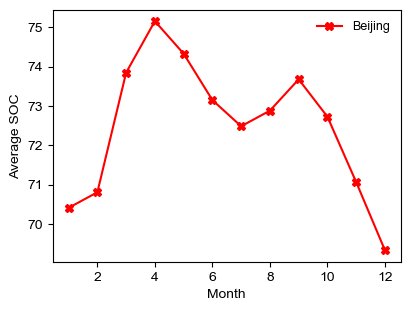

In [17]:
    #---------------------------------------------------------------------------------------------------------#
    # Average SOC
    # Compute the average SOC use across regions and during different months.
    #---------------------------------------------------------------------------------------------------------#
    bj_arr = np.array(bj_list)
    fig = plt.figure(figsize=(4, 3))
    plt.subplots_adjust(left=0.12, bottom=0.15, right=0.99, top=0.99)
    ax = fig.add_subplot(111)
    ax.plot(np.arange(1, 13, 1), bj_arr[:, 0], '-X', color='r', label='Beijing')
    ax.set_xlabel('Month')
    ax.set_ylabel('Average SOC')
    ax.legend(fontsize=9, frameon=False)